# Predicting the gender of the judges based on the other related criterias

In [126]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/courts-data/judges_clean/judges_clean.csv
/kaggle/input/courts-data/acts_sections/acts_sections.csv
/kaggle/input/courts-data/cases/cases/cases_2015.csv
/kaggle/input/courts-data/cases/cases/cases_2012.csv
/kaggle/input/courts-data/cases/cases/cases_2018.csv
/kaggle/input/courts-data/cases/cases/cases_2013.csv
/kaggle/input/courts-data/cases/cases/cases_2017.csv
/kaggle/input/courts-data/cases/cases/cases_2010.csv
/kaggle/input/courts-data/cases/cases/cases_2014.csv
/kaggle/input/courts-data/cases/cases/cases_2016.csv
/kaggle/input/courts-data/cases/cases/cases_2011.csv
/kaggle/input/courts-data/keys/keys/type_name_key.csv
/kaggle/input/courts-data/keys/keys/cases_district_key.csv
/kaggle/input/courts-data/keys/keys/act_key.csv
/kaggle/input/courts-data/keys/keys/disp_name_key.csv
/kaggle/input/courts-data/keys/keys/purpose_name_key.csv
/kaggle/input/courts-data/keys/keys/cases_state_key.csv
/kaggle/input/courts-data/keys/keys/section_key.csv
/kaggle/input/courts-data/key

# Loading up the dataset

In [127]:
df = pd.read_csv('/kaggle/input/courts-data/judges_clean/judges_clean.csv')
df.head()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014
1,2,1,1,1,chief judicial magistrate,0 nonfemale,31-10-2013,20-02-2014
2,3,1,1,1,chief judicial magistrate,0 nonfemale,21-02-2014,31-05-2016
3,4,1,1,1,chief judicial magistrate,0 nonfemale,01-06-2016,06-06-2016
4,5,1,1,1,chief judicial magistrate,0 nonfemale,06-06-2016,07-07-2018


# Cleaning the dataset

### Checking for Null values

In [130]:
bad = df['state_code'].isna().sum()
print(bad)

0


In [131]:
bad = df['dist_code'].isna().sum()
print(bad)

0


In [132]:
bad = df['court_no'].isna().sum()
print(bad)

0


In [133]:
bad = df['judge_position'].isna().sum()
print(bad)

0


In [134]:
bad = df['female_judge'].isna().sum()
print(bad)

1


In [135]:
df = df.dropna(subset = ['female_judge'])

In [136]:
bad = df['female_judge'].isna().sum()
print(bad)

0


In [137]:
bad = df['start_date'].isna().sum()
print(bad)

0


In [138]:
bad = df['end_date'].isna().sum()
print(bad)

18158


In [142]:
df = df.dropna(subset = ['end_date'])

In [143]:
bad = df['end_date'].isna().sum()
print(bad)

0


In [144]:
df = df.reset_index(drop=True)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80319 entries, 0 to 80318
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ddl_judge_id    80319 non-null  int64 
 1   state_code      80319 non-null  int64 
 2   dist_code       80319 non-null  int64 
 3   court_no        80319 non-null  int64 
 4   judge_position  80319 non-null  object
 5   female_judge    80319 non-null  object
 6   start_date      80319 non-null  object
 7   end_date        80319 non-null  object
dtypes: int64(4), object(4)
memory usage: 4.9+ MB


### Removing the unclear values for the gender category

In [146]:
genders = df['female_judge'].unique()
print(genders)

['0 nonfemale' '1 female' '-9998 unclear']


In [147]:
df = df.loc[(df['female_judge'] != '-9998 unclear')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77051 entries, 0 to 80318
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ddl_judge_id    77051 non-null  int64 
 1   state_code      77051 non-null  int64 
 2   dist_code       77051 non-null  int64 
 3   court_no        77051 non-null  int64 
 4   judge_position  77051 non-null  object
 5   female_judge    77051 non-null  object
 6   start_date      77051 non-null  object
 7   end_date        77051 non-null  object
dtypes: int64(4), object(4)
memory usage: 5.3+ MB


In [148]:
df = df.reset_index(drop = True)

### Cleaning up the corpus more for the judge_positions category

In [150]:
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

In [151]:
positions = df['judge_position'].unique()
positions.sort()
print(positions)

['1-additional additional district judge'
 '1-additional chief judicial magistrate'
 '1-additional civil judge and judicial magistrate'
 '1-additional civil judge junior division'
 '1-additional district and sessions court' '1-additional district judge'
 '1-additional pocso' '1-cbi court' '1-chief judicial magistrate'
 '1-district and sessions court' '1-fast track court' '1-jmfc'
 '1-judicial magistrate court' '1-mm court' '1-munsiff'
 '1-principal judge family court' '1-principal judicial magistrate court'
 '1-subdivisional judicial magistrate'
 '10-additional chief judicial magistrate'
 '10-additional district and sessions court' '10-jmfc'
 '10-special court for atrocities against women' '10th a.d.j'
 '11-additional chief judicial magistrate'
 '11-additional district and sessions court' '11-cbi court' '11th a.d.j'
 '12-additional chief judicial magistrate'
 '12-additional district and sessions court'
 '12-additional district judge' '12-metropolitan magistrate court'
 '13-additional c

In [152]:
df['judge_position'] = df['judge_position'].str.strip()

In [154]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 60):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 60
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")

In [155]:
good_positions = ['additional additional district judge'
 'additional civil judge and judicial magistrate'
 'additional civil judge junior division'
 'additional district and sessions court' 
 'additional district judge'
 'additional pocso' 
 'cbi court' 
 'chief judicial magistrate'
 'district and sessions court' 
 'fast track court' 
 'judicial magistrate court' 
 'mm court' 
 'munsiff'
 'principal judge family court' 
 'principal judicial magistrate court'
 'subdivisional judicial magistrate'
 'additional district and sessions court' 
 'special court for atrocities against women' 
 'additional district and sessions court' 
 'metropolitan magistrate court'
 'additional district judge' 
 'additional civil judge and judicial magistrate'
 'additional civil judge junior division'
 'additional district and sessions court' 
 'additional district judge'
 'additional jmfc' 
 'additional judicial magistrate court'
 'additional munsiff' 
 'chief judicial magistrate'
 'civil judge junior division' 
 'criminal cases'
 'district and sessions court' 
 'jmfc'
 'judicial magistrate court'
 'mm court' 
 'munsiff' 
 'principal civil judge' 
 'principal judge'
 'principal judge family court' 
 'railway ner' 
 'sc st' 
 'a.s.j.' 
 'additional civil judge and judicial magistrate'
 'additional civil judge senior division'
 'additional district and sessions court' 
 'additional district judge'
 'additional judicial magistrate court' 
 'chief judicial magistrate'
 'exclusive special court of excise act,muzaffarpur' 
 'judicial magistrate court' 
 'mm court'
 'subdivisional judicial magistrate'
 'additional civil judge and judicial magistrate'
 'additional district and sessions court' 
 'additional district judge'
 'subdivisional judicial magistrate' 
 'additional chief metropolitan magistrate'
 'additional district and sessions court' 
 'additional district judge'
 'additional munsii' 
 'additional munsiff' 
 'judicial magistrate court' 
 'metropolitan magistrate traffic court'
 'munsiff' 
 'subdivisional judicial magistrate' 
 'additional district and sessions court'  
 'additional chief judicial magistrate'
 'additional district and sessions court'
 'district and sessions court' 
 'additional district judge'
 'additional district and sessions court'  
 '5 cum spl. court mp/mla/mlc' 
 'cum special judge excise'
 'cuspl. judge' 
 'a.o. special court vigilance'
 'acb court karimnagar' 
 'acb court, kurnool' 
 'acd alwar district hq'
 'acd court' 
 'acd jodhpur metro hq' 
 'acd kota hq'
 'acd udaipur district hq' 
 'acj court' 
 'additional cbi court'
 'additional chief metropolitan magistrate'
 'additional civil judge and judicial magistrate'
 'additional civil judge junior division'
 'additional civil judge senior division' 'additional court'
 'additional deputy commissioner' 'additional district and sessions court'
 'additional district judge' 'additional district munsiff first class'
 'additional judicial magistrate court' 'additional labour'
 'additional metropolitan magistrate'
 'additional motor accidents claims tribunal' 'additional munsiff'
 'additional small cause court'
 'additional special court for the exclusive trail of ec act cases'
 'additional special sessions court' 'additional sub court'
 'additional subdivisional judicial magistrate' 'adhoc  4'
 'adhoc  ist' 'adhoc .' 'adhoc . 4th' 'adhoc . spl.'
 'adhoc addl. distt. and sess. judge'
 'aditional principal judge'
 'am 1st' 'am 2nd' 'am 3rd' 'am2' 'atrauli' 'berhampore criminal'
 'bidhanagar court complex' 'camp court' 'cantonment court' 'cbi court'
 'cbi jodhpur metro hq' 'chief judge court' 'chief judicial magistrate'
 'chief metropolitan magistrate' 'city civil and sessions court'
 'city district and sessions court' 'civil cases' 'civil court'
 'civil judge' 'civil judge junior division' 'civil judge senior division'
 'cj anta taluka' 'cj atru taluka' 'cj chhipabarod taluka'
 'cj kishanganj taluka' 'commercial court' 'commercialjodhpur metro hq'
 'consumer forun jowai' 'cooperative court'
 'court n4 ,j.m 1st class,muz. east'
 'court no. 6 of j.m 1st class, muzaffarpur east' 'criminal cases'
 'district and additional sessions court' 'district and sessions court'
 'district court' 'district munsiff first class'
 'district musif court, rasipuram'
 'establishment of civil judge sr. division, gangtok, east sikkim'
 'establishment of civil judge sr. division, mangan north sikkim'
 'establishment of civil judge sr. division, south sikkim'
 'establishment of civil judge sr. division, west sikkim' 'evening court'
 'exclusive special court of excise act,muzaffarpur' 'f.t.ci'
 'f.t.cii' 'family court' 'fast track court' 'fcj courts, kadapa'
 'first class magistrate ii, ottappalam' 'ftc i' 'ftc judge' 'ft1'
 'ft2' 'fti' 'ftii' 'gram nyayalaya'
 'i metropolitan magistrate, municipal complex, hyd.' '12th '
 '1st a.s.j.' 'munsif i' 'p.o. spl. court of drug and cosmatic act'
 'p.o. spl. court of p.o.c.s.o. act 2012' 'principal magistrate'
 'special court of vigilance' 'spl. judge, food safety act'
 'sub judgii' 'sujudge 3rd cum d.l.s.a. banka' 'sujudge 6th'
 'sujudgiv' 'ic principal judge' 'i. 1st'
 'iadditional munsif 4th' 'iadditional munsif 8th' 'imunsif ii'
 'iprincipal judge' 'isadar addl. munsif 3'
 'ispl. court the bihar prohibition and excise act, 2016'
 'ispl. judge, food safety act' 'isub judge 3rd' 'isub judge iv'
 'isub judgii' 'isub judgvi' 'iisub judge 7th' 'iisub judgi'
 'iisujudge 3rd cum d.l.s.a. banka'
 'incharge spl judge prevention of money laundering act'
 'incharge spl. court the bihar prohibition and exice act, 2016'
 'industrial court' 'i1st ' 'iadditional munsif 15' 'ift1'
 'imunsif' 'imunsif 1' 'imunsif 2' 'imunsif 3' 'imunsif 4'
 'isub judge 3rd' 'ix addl.distriict and sessionscourt, wanaparthy'
 'j m'  
 'j.m 1st class' 'j.m 1st class cum addl. munsiii'
 'j.m 1st class cum addl. munsiix' 'j.m 1st class cum addl. munsivi'
 'j.m 1st class cum addl.munsivii' 'j.m 1st classcum addl. munsiviii'
 'j.m 2nd class' 'j.m 2nd class,muzaffarpur east' 'j.ii' 'j.iii'
 'j.m. 1st' 'j.m. 1st class' 'j.m. 1st class court no. 1'
 'j.m. 1st class cum addl. a.m. 1' 'j.m. 1st class cum addl. a.m. 2'
 'j.m. 1st clasiind' 'j.m. 2nd class' 'j.m. 2nd class court no. 1'
 'j.m. ist clascuaddl. munsif' 'j.mi' 'j.m.st clasii'
 'j.m.ist class' 'j.m.ist clascuaddl.munsif i'
 'j.m.ist clascuaddl.munsif ii' 'j.m.ist clascuaddl.munsif iii'
 'j.m.ist clascuaddl.munsif iv' 'jcj court, puttaparthy'
 'jcj courts, satyavedu'  'judge isujudgii'
 'judgichargecum addl.munsiiii' 'judicial magistrate court'
 'judicial officer 2nd clasi' 'judicial officer 2nd clasii'
 'junior division' 'juvenile court' 'labour court'
 'magistrate court, nalgonda' 'mahila court'
 'metropolitan magistrate court' 'metropolitan magistrate traffic court'
 'mobile and excise court' 'motor accidents claims tribunal' 'msj court'
 'municipal court' 'munsif' 'munsif 1' 'munsif 1st' 'munsif 2'
 'munsif 2nd' 'munsif 3' 'munsif 4' 'munsif i' 'munsif ii' 'munsii'
 'munsiii' 'munsiff' 'munsiff first class court'
 'munsiff magistrate court' 'nandigama sr. courts' 'ndps' 'outlying court'
 'p.o. spl court pesu area' 'p.o. spl. court for economic offences'
 'p.o. spl. court of drug and cosmatic act'
 'p.o. spl. court of p.o.c.s.o. act 2012' 'pdj courts, kothagudem' 'pocso'
 'polc and poit' 'porahat division' 'presiding officer'
 'presiding officer ftc ii' 'presiding officer, ind. tribunal, hubballi'
 'principal chief judicial magistrate' 'principal civil judge'
 'principal civil judge junior division'
 'principal civil judge senior division'
 'principal district and sessions court' 'principal district judge'
 'principal district munsiff first class' 'principal judge'
 'principal judge , family judge' 'principal judge family court'
 'principal juvenile court' 'principal magistrate' 'principal munsiff'
 'principal munsiff first class court' 'principal sub court'
 'principle judge' 'print stationary cbi jaipur dist hq' 'railway ner'
 'registracuaddl. munsiiii' 'rent tribunal'
 'sadar addl. munsif 10' 'sc st' 'school tribunal' 'sd shahbad taluka'
 'sikrahana addl. munsif 1' 'small cause court'
 'spcl court bharatpur district hq' 'spcl dholpur district hq'
 'special court for land grabing cases' 'special court for nia cases'
 'special court for the exclusive trail of ec act cases'
 'special court for the exclusive trial of prevention of corruption act cases, tirunelveli'
 'special court for trial of cases under prevention of corruption act'
 'special court land acquisition, jowai'
 'special court of c.b.i, muzaffarpur'
 'special court of economic offences, muzaffarpur'
 'special court of excise'
 'special court of immoral traffic prevention act 1956,muzaffarpur'
 'special court of vigilance'
 'special court prevention of corruption ,jowai'
 'special court to deal with laop cases'
 'special court under n.b.p.d.c.l,tirhut area,muzaffarpur'
 'special court under tnpid act'
 'special court,sc and st p.a. act, cuttack' 'special couri, vigilance'
 'special courii' 'special courts, jayankondam' 'special excise court'
 'special for the exclusive trial of prevention of corruption act cases, salem'
 'special judge' 'special judge excise' 'special judge s.c. and s.t'
 'special judge vigilance ii' 'special judge,electricity' 'special judges'
 'special magistrate court' 'special mobile court'
 'special sessions court' 'spl court cbi'
 'spl court vigilance '
 'spl judge comm riots jaipur metro hq' 'spl judge vigilance i'
 'spl judge vigilance trap'
 'spl. court the bihar prohibition and excise act, 2016'
 'spl. court alang, bhavnagar' 'spl. court for child act'
 'spl. judge n.i.a., patna' 'spl. judge, excise act'
 'spl. judge, food safety act'
 'spl. judge, prevention of money laundering act'
 'spl.court for trial of spe and acb cases at rajamahendravaram'
 'spl.judge mp/mla/mlc' 'sri j.mcuaddl. munsif'
 'sri jitendra mishra a. i'
 'sri jitesh kumar j.mcuaddl. munsivi' 'sri kumud ranjan 2nd class'
 'sri nand kishor prasad gupta a. iii'
 'state transport appellate tribunal' 'sub court' 'sub judge'
 'subdivisional judicial magistrate' 'successor principal judge'
 'successor spl judge nia patna' 'successor, spl judge food safety act'
 'taluka court' 'tiruvuru court ,krishna' 'transport tribunal'
 'j.m.ist class' 'vacant courprincipal magistrate'
 'vacanspl judge vigilance trap' 'vacation' 'wac' 'wakf tribunal'
 'womens court'
 'x additional special court for prevention of corruption act, singaravelar maligai, george town , chennai']

In [156]:
for position in good_positions:
    replace_matches_in_column(df = df, column = 'judge_position', string_to_match = position)

All done!


# Building the Model

## Creating the initial features for classification

In [157]:
df.head()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014
1,2,1,1,1,chief judicial magistrate,0 nonfemale,31-10-2013,20-02-2014
2,3,1,1,1,chief judicial magistrate,0 nonfemale,21-02-2014,31-05-2016
3,4,1,1,1,chief judicial magistrate,0 nonfemale,01-06-2016,06-06-2016
4,5,1,1,1,chief judicial magistrate,0 nonfemale,06-06-2016,07-07-2018


### Encoding the categorical units to obtain feature points

In [158]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['judge_position_cat'] = labelencoder.fit_transform(df['judge_position'])
df

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date,judge_position_cat
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,193
1,2,1,1,1,chief judicial magistrate,0 nonfemale,31-10-2013,20-02-2014,193
2,3,1,1,1,chief judicial magistrate,0 nonfemale,21-02-2014,31-05-2016,193
3,4,1,1,1,chief judicial magistrate,0 nonfemale,01-06-2016,06-06-2016,193
4,5,1,1,1,chief judicial magistrate,0 nonfemale,06-06-2016,07-07-2018,193
...,...,...,...,...,...,...,...,...,...
77046,98472,30,2,8,criminal cases,1 female,04-04-2016,15-12-2016,212
77047,98474,30,2,9,criminal cases,1 female,21-04-2004,14-11-2013,212
77048,98475,30,2,9,criminal cases,1 female,16-01-2015,16-01-2016,212
77049,98476,30,2,9,criminal cases,1 female,09-12-2016,31-07-2017,212


In [160]:
df['gender_cat'] = labelencoder.fit_transform(df['female_judge'])
df

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date,judge_position_cat,gender_cat
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,193,0
1,2,1,1,1,chief judicial magistrate,0 nonfemale,31-10-2013,20-02-2014,193,0
2,3,1,1,1,chief judicial magistrate,0 nonfemale,21-02-2014,31-05-2016,193,0
3,4,1,1,1,chief judicial magistrate,0 nonfemale,01-06-2016,06-06-2016,193,0
4,5,1,1,1,chief judicial magistrate,0 nonfemale,06-06-2016,07-07-2018,193,0
...,...,...,...,...,...,...,...,...,...,...
77046,98472,30,2,8,criminal cases,1 female,04-04-2016,15-12-2016,212,1
77047,98474,30,2,9,criminal cases,1 female,21-04-2004,14-11-2013,212,1
77048,98475,30,2,9,criminal cases,1 female,16-01-2015,16-01-2016,212,1
77049,98476,30,2,9,criminal cases,1 female,09-12-2016,31-07-2017,212,1


### Converting the dates to feature points

In [161]:
df['start_date'] = pd.to_datetime(df['start_date'], format='%d-%m-%Y', errors = 'coerce')
df['end_date'] = pd.to_datetime(df['end_date'], format='%d-%m-%Y', errors = 'coerce')

df = df.dropna(subset = ['start_date'])
df = df.dropna(subset = ['end_date'])
    
df = df.loc[(df['start_date'] >= '2010-01-01') & (df['start_date'] <= '2023-01-01') & (df['end_date'] >= '2010-01-01') & (df['end_date'] <= '2023-01-01')]
df = newdf.reset_index(drop=True)
print(df.shape)

(73195, 10)


In [162]:
df['start_date_year'] = df['start_date'].dt.year
df['start_date_month'] = df['start_date'].dt.month
df['start_date_day'] = df['start_date'].dt.day
df

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date,judge_position_cat,gender_cat,start_date_year,start_date_month,start_date_day
0,1,1,1,1,chief judicial magistrate,0 nonfemale,2013-09-20,2014-02-20,193,0,2013,9,20
1,2,1,1,1,chief judicial magistrate,0 nonfemale,2013-10-31,2014-02-20,193,0,2013,10,31
2,3,1,1,1,chief judicial magistrate,0 nonfemale,2014-02-21,2016-05-31,193,0,2014,2,21
3,4,1,1,1,chief judicial magistrate,0 nonfemale,2016-06-01,2016-06-06,193,0,2016,6,1
4,5,1,1,1,chief judicial magistrate,0 nonfemale,2016-06-06,2018-07-07,193,0,2016,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73190,98471,30,2,8,criminal cases,0 nonfemale,2014-10-18,2016-04-04,212,0,2014,10,18
73191,98472,30,2,8,criminal cases,1 female,2016-04-04,2016-12-15,212,1,2016,4,4
73192,98475,30,2,9,criminal cases,1 female,2015-01-16,2016-01-16,212,1,2015,1,16
73193,98476,30,2,9,criminal cases,1 female,2016-12-09,2017-07-31,212,1,2016,12,9


In [163]:
df['end_date_year'] = df['end_date'].dt.year
df['end_date_month'] = df['end_date'].dt.month
df['end_date_day'] = df['end_date'].dt.day
df

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date,judge_position_cat,gender_cat,start_date_year,start_date_month,start_date_day,end_date_year,end_date_month,end_date_day
0,1,1,1,1,chief judicial magistrate,0 nonfemale,2013-09-20,2014-02-20,193,0,2013,9,20,2014,2,20
1,2,1,1,1,chief judicial magistrate,0 nonfemale,2013-10-31,2014-02-20,193,0,2013,10,31,2014,2,20
2,3,1,1,1,chief judicial magistrate,0 nonfemale,2014-02-21,2016-05-31,193,0,2014,2,21,2016,5,31
3,4,1,1,1,chief judicial magistrate,0 nonfemale,2016-06-01,2016-06-06,193,0,2016,6,1,2016,6,6
4,5,1,1,1,chief judicial magistrate,0 nonfemale,2016-06-06,2018-07-07,193,0,2016,6,6,2018,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73190,98471,30,2,8,criminal cases,0 nonfemale,2014-10-18,2016-04-04,212,0,2014,10,18,2016,4,4
73191,98472,30,2,8,criminal cases,1 female,2016-04-04,2016-12-15,212,1,2016,4,4,2016,12,15
73192,98475,30,2,9,criminal cases,1 female,2015-01-16,2016-01-16,212,1,2015,1,16,2016,1,16
73193,98476,30,2,9,criminal cases,1 female,2016-12-09,2017-07-31,212,1,2016,12,9,2017,7,31


## Declaring the Features or the axis 

In [164]:
features = ['start_date_year', 'start_date_month', 'start_date_day', 'end_date_year', 'end_date_month', 'end_date_day', 'state_code', 'dist_code', 'court_no', 'judge_position_cat']
X = np.array(df[features])
y = np.array(df['gender_cat'])

## Splitting into training and testing data

In [179]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Scaling the training points

In [181]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

# Model 1: Logistic Regression

### Running the model

In [182]:
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression(max_iter = 1000)
reg_log.fit(X_train, y_train)
y_pred = reg_log.predict(X_test)

### Precision and Performance

In [183]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84     10599
           1       0.00      0.00      0.00      4040

    accuracy                           0.72     14639
   macro avg       0.36      0.50      0.42     14639
weighted avg       0.52      0.72      0.61     14639



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
score = reg_log.score(X_test, y_test)
print(score)

0.7240248650864131


### Confusion Matrix

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [186]:
cm = metrics.confusion_matrix(y_test, y_pred)

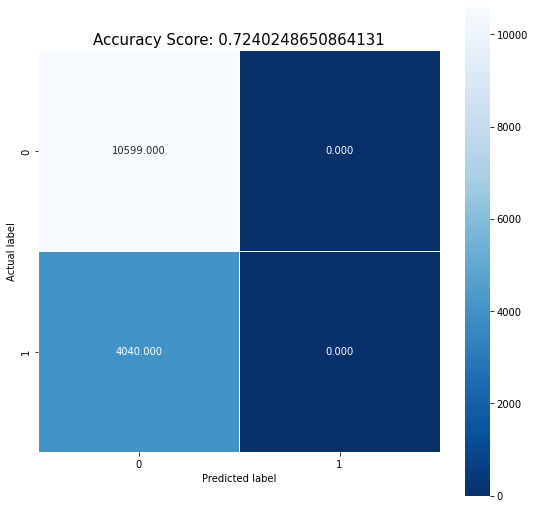

In [187]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Method 2: Random Forest Classifier

### Running the Model

In [189]:
from sklearn.ensemble import RandomForestClassifier
reg_rf = RandomForestClassifier()
reg_rf.fit(X_train, y_train)
y_pred = reg_rf.predict(X_test)

### Performance and Precision

In [190]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     10599
           1       0.58      0.33      0.42      4040

    accuracy                           0.75     14639
   macro avg       0.68      0.62      0.63     14639
weighted avg       0.73      0.75      0.72     14639



In [191]:
score = reg_rf.score(X_test, y_test)
print(score)

0.7499146116538015


### Importance of the features 


In [192]:
feature_df = pd.DataFrame({'Importance':reg_rf.feature_importances_, 'Features': features })
print(feature_df)

   Importance            Features
0    0.062362     start_date_year
1    0.081013    start_date_month
2    0.120196      start_date_day
3    0.053729       end_date_year
4    0.076496      end_date_month
5    0.121966        end_date_day
6    0.061578          state_code
7    0.142333           dist_code
8    0.199327            court_no
9    0.080999  judge_position_cat


### Confusion Matrix

In [193]:
cm = metrics.confusion_matrix(y_test, y_pred)

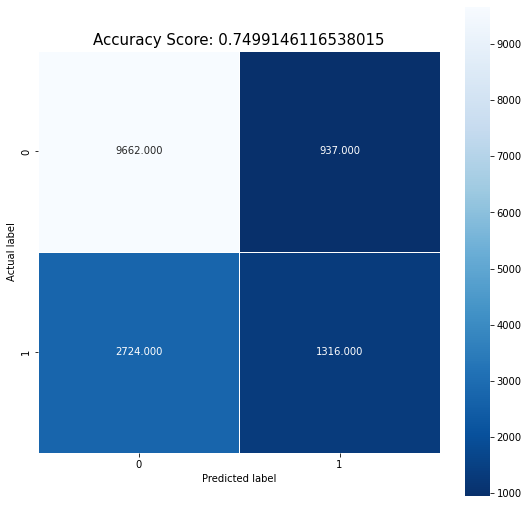

In [194]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Method 3: K Nearest Neighbours

### Running the Model

In [204]:
from sklearn.neighbors import KNeighborsClassifier
reg_knn = RandomForestClassifier()
reg_knn.fit(X_train, y_train)
y_pred = reg_knn.predict(X_test)

### Precision and Performance

In [205]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     10599
           1       0.58      0.33      0.42      4040

    accuracy                           0.75     14639
   macro avg       0.68      0.62      0.63     14639
weighted avg       0.72      0.75      0.72     14639



In [206]:
score = reg_knn.score(X_test, y_test)
print(score)

0.7489582621763782


### Importance of the features

In [207]:
feature_df = pd.DataFrame({'Importance':reg_knn.feature_importances_, 'Features': features })
print(feature_df)

   Importance            Features
0    0.061513     start_date_year
1    0.080586    start_date_month
2    0.120222      start_date_day
3    0.053358       end_date_year
4    0.077922      end_date_month
5    0.123085        end_date_day
6    0.062068          state_code
7    0.142092           dist_code
8    0.198322            court_no
9    0.080832  judge_position_cat


### Confusion Matrix

In [208]:
cm = metrics.confusion_matrix(y_test, y_pred)

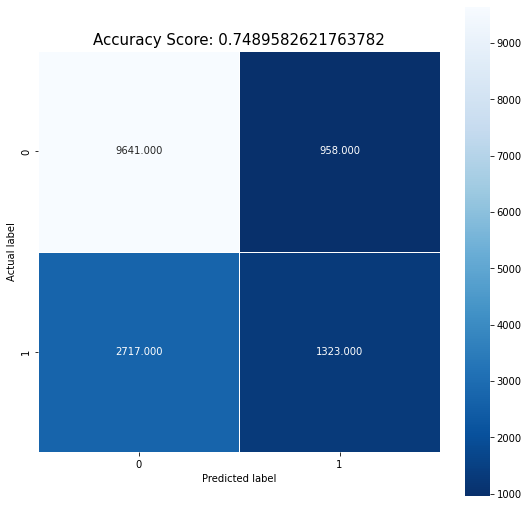

In [209]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Method 4: Naive Bayes

### Running the Model

In [211]:
from sklearn.naive_bayes import GaussianNB
reg_gnb = GaussianNB()
reg_gnb.fit(X_train, y_train)
y_pred = reg_gnb.predict(X_test)

### Performance and Precision

In [212]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83     10599
           1       0.33      0.04      0.08      4040

    accuracy                           0.71     14639
   macro avg       0.53      0.50      0.45     14639
weighted avg       0.62      0.71      0.62     14639



In [214]:
score = reg_gnb.score(X_test, y_test)
print(score)

0.7116606325568686


### Confusion Matrix

In [220]:
cm = metrics.confusion_matrix(y_test, y_pred)

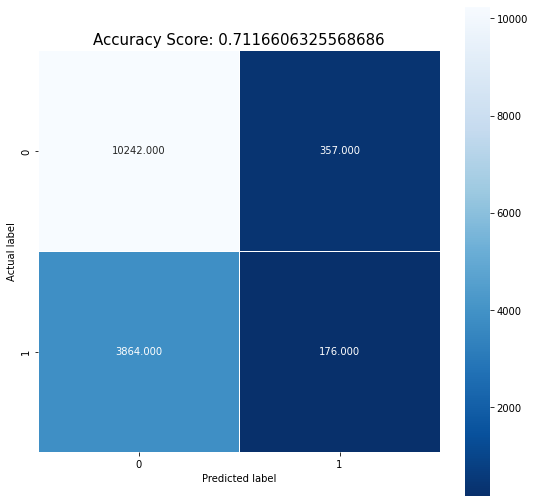

In [221]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Method 5: Support Vector Machines

### Running the Model

In [222]:
from sklearn.svm import SVC
reg_svc = SVC()
reg_svc.fit(X_train, y_train)
y_pred = reg_svc.predict(X_test)

### Performance and Precision

In [223]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84     10599
           1       0.00      0.00      0.00      4040

    accuracy                           0.72     14639
   macro avg       0.36      0.50      0.42     14639
weighted avg       0.52      0.72      0.61     14639



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [225]:
score = reg_svc.score(X_test, y_test)
print(score)

0.7240248650864131


### Confusion Matrix

In [228]:
cm = metrics.confusion_matrix(y_test, y_pred)

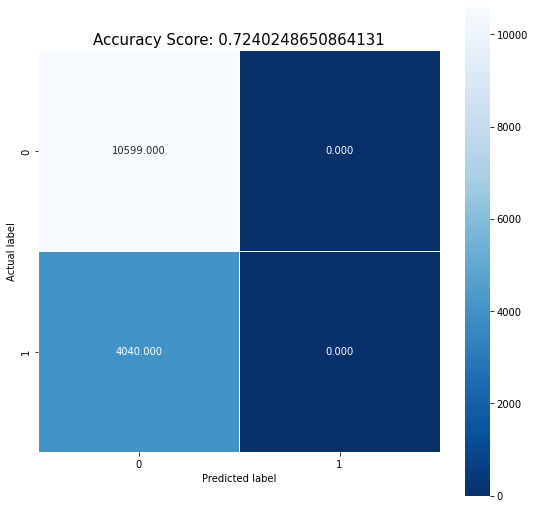

In [229]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Method 6: Neural Network

### Running the Model

In [231]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier()
NN.fit(X_train, y_train)
y_pred = NN.predict(X_test)

### Performance and Precision

In [232]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81     10599
           1       0.36      0.13      0.19      4040

    accuracy                           0.70     14639
   macro avg       0.55      0.52      0.50     14639
weighted avg       0.63      0.70      0.64     14639



In [233]:
score = NN.score(X_test, y_test)
print(score)

0.6962224195641779


### Confusion Matrix

In [234]:
cm = metrics.confusion_matrix(y_test, y_pred)

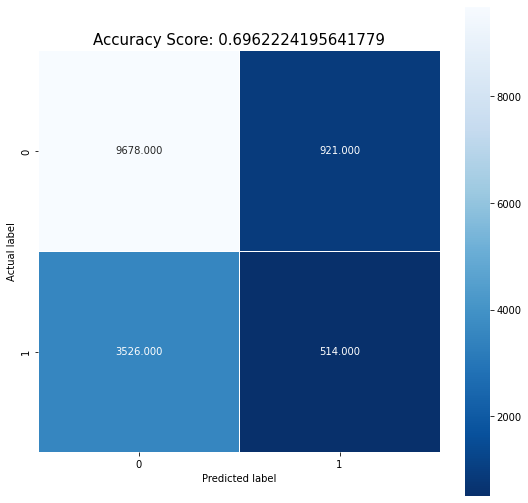

In [235]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);